<h1 style="text-align:center;font-size:50px;" > Severstal: Steel Defect Detection </h1>

![alt text](https://drive.google.com/uc?id=14XiYMQgRKb6DwHRR9o4F29NBmFETyMC1)

# 1.0 Business Problem

## 1.1 Description

Severstal is leading the charge in efficient steel mining and production. With over 50K employees, 5K clients, and 25K products, this company has produced 11.8 Million tonnes of steel, 4.7 Million tonnes of coal and 11 Million tonnes of iron core pellets in 2019 which justifies its dominance in the steel industry.

We know that steel is one of the most important and most widely used building materials of modern times due to its impressive properties like durability, thermal conductivity, resistance to natural and man-made wear and most importantly it is resistant to corrosion which makes the material ubiquitous around the world. In order to make steel production more efficient without compromising the quality, Severstal wants to leverage the advances of Artificial Intelligence like computer vision to identify defects in delicate flat steel sheets. These sheets are produced from a sequence of manufacturing processes that involves heating, rolling, drying and cutting

Off lately, Severstal is using images generated form high frequency cameras to power a defect detection algorithm and  Severstal is expecting the AI engineers to improve the algorithm to detect defects with high precision.

Credits: Kaggle 

__ Problem Statement __
- Detect and localize the surface defects on a steel sheet provided the image of steel sheets.
- Classify the detected surface defects  into one or multiple classes among class values [1, 2, 3, 4]

## 1.2 Sources/Useful Links

- Source : https://www.kaggle.com/c/severstal-steel-defect-detection/overview
<br><br>____ Useful Links ____
- References : 
- https://forums.fast.ai/t/understanding-the-dice-coefficient/5838
- https://www.kaggle.com/wh1tezzz/correct-dice-metrics-for-this-competition
- https://lmb.informatik.uni-freiburg.de/people/ronneber/u-net/
- https://www.kaggle.com/go1dfish/clear-mask-visualization-and-simple-eda
- https://www.kaggle.com/cdeotte/keras-unet-with-eda
- https://stanford.edu/~shervine/blog/keras-how-to-generate-data-on-the-fly

## 1.3 Real world/Business Objectives and Constraints

1. No strict latency concerns.
2. Interpretability can be obtained in the form of probability values for each of 4 class labels.

# 2.0 Machine Learning Probelm

## 2.1 Data

### 2.1.1 Data Overview

The data folder (size 2GB in total) provided by Severstal contains the following:

- train_images/ - folder of training images
- test_images/ - folder of test images (you are segmenting and classifying these images)
- train.csv - training annotations which provide segments for defects (ClassId = [1, 2, 3, 4])
- sample_submission.csv - a sample submission file in the correct format, with each ImageId repeated 4 times, one for each     of the 4 defect classes

### 2.1.2 Example Data point

**Sample train image**

![sample](https://drive.google.com/uc?id=1bCZOwQ2K_Hy9-6D61ua2xDJypFa4YM7w)

**train_csv data point**

![sample](https://drive.google.com/uc?id=1Aa8lxmO4ULuMKWrtw9hzXK5zG8TQgdro)

## 2.2 Mapping the real world problem to an ML problem 

### 2.2.1 Type of Machine Leaning Problem 

- This is an image segmentation and a classification problem to predict, localize the defects and then classify the detected defects

### 2.2.2 Performance Metric

- Dice coefficient. 
- https://forums.fast.ai/t/understanding-the-dice-coefficient/5838
- https://en.wikipedia.org/wiki/S%C3%B8rensen%E2%80%93Dice_coefficient

## 2.3 Train, CV and Test construction 

- Training images will be split randomly into train & CV in the ratio 80:20 or 90:10.
- Testing images will be used for predictions.

# 3.0 Exploratory Data Analysis

### Importing all the modules

In [0]:
import warnings
warnings.filterwarnings("ignore")
from datetime import datetime
import pandas as pd
import numpy as np
from numpy import asarray
import matplotlib.pyplot as plt
%matplotlib notebook
%matplotlib inline
import seaborn as sns
from sklearn import metrics
import pickle
from tqdm import tqdm
import math
import random
import os
import cv2
from collections import Counter
from os import listdir
from matplotlib import image
from matplotlib import pyplot
from PIL import Image
from collections import defaultdict
from sklearn.model_selection import train_test_split
import tensorflow as tf
from keras import backend as K
from keras.losses import binary_crossentropy
from keras.layers import UpSampling2D, Conv2D, Activation, LeakyReLU, BatchNormalization,Input,Conv2DTranspose,Dropout
from keras.layers.pooling import MaxPooling2D, GlobalMaxPool2D
from keras import Model
from keras.preprocessing.image import ImageDataGenerator,array_to_img, img_to_array, load_img
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint, LearningRateScheduler,Callback
from keras.optimizers import Adam
from tqdm import tqdm_notebook
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import concatenate,add

Using TensorFlow backend.


## 3.1 Loading train csv file

In [0]:
#loading the train csv file containing pixels indicating defects  
train_df= pd.read_csv("/content/train.csv")
train_df.head()

,ImageId,ClassId,EncodedPixels
0,0002cc93b.jpg,1,29102 12 29346 24 29602 24 29858 24 30114 24 3...
1,0007a71bf.jpg,3,18661 28 18863 82 19091 110 19347 110 19603 11...
2,000a4bcdd.jpg,1,37607 3 37858 8 38108 14 38359 20 38610 25 388...
3,000f6bf48.jpg,4,131973 1 132228 4 132483 6 132738 8 132993 11 ...
4,0014fce06.jpg,3,229501 11 229741 33 229981 55 230221 77 230468...


EncodedPixels columns indicate run-length encoding on the pixel values which are pairs of values that contain a start position and a run length. E.g. '1 3' implies starting at pixel 1 and running a total of 3 pixels (1,2,3).

The competition format requires a space delimited list of pairs. For example, '1 3 10 5' implies pixels 1,2,3,10,11,12,13,14 are to be included in the mask. The metric checks that the pairs are sorted, positive, and the decoded pixel values are not duplicated. The pixels are numbered from top to bottom, then left to right: 1 is pixel (1,1), 2 is pixel (2,1), etc.

In [0]:
print(train_df.shape)

(7095, 3)


- There are 7095 datapoints or steel sheet images containing defects

## 3.2 Checking for NaN

In [0]:
# train data
nan_rows = train_df[train_df.isnull().any(axis=1)]
nan_rows

,ImageId,ClassId,EncodedPixels


- There are no NaN's

## 3.3 Analysing train & test image folders

### 3.3.1 Number of  train & test images

Number of images in the train folder:  12568
Number of images in the test folder:  5506
----------------------------------------------------------------------------------------------------


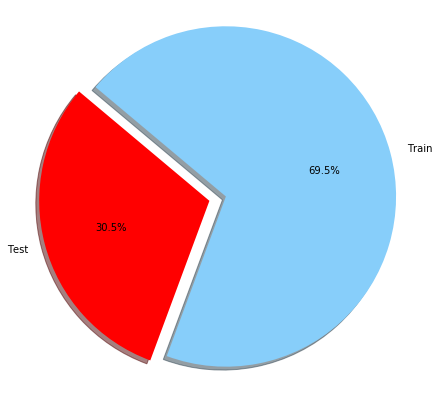

In [0]:
train_count= 0 
test_count= 0  

for filename in listdir('train_images'):
    #counting number of images in train folder
    train_count+=1 
for filename in listdir('test_images'):
    #counting number of images in test folder
    test_count+=1

print("Number of images in the train folder: ",train_count)
print("Number of images in the test folder: ",test_count)
print('-'*100)

#Pie-chart https://pythonspot.com/matplotlib-pie-chart/
# Data to plot
labels = 'Test', 'Train'
sizes = [test_count,train_count]
colors = ['red','lightskyblue']
explode = (0.1, 0)  # explode 1st slice

# Plot
plt.figure(figsize=(7,7))
plt.pie(sizes, explode=explode, labels=labels, colors=colors,
autopct='%1.1f%%', shadow=True, startangle=140)

plt.axis('equal')
plt.show()

#### Looks like there is difference in image count in train folder & the imageID in train.csv

In [0]:
print("Number of images in the train folder which do not have defects are:",(train_count-train_df.shape[0]))

Number of images in the train folder which do not have defects are: 5473


### 3.3.2 Printing few sample images containing no defects

In [0]:
# load all images in a directory
#from os import listdir
from matplotlib import image
# load all images in a directory
loaded_images = list()
defects= list(train_df.ImageId.values)
for filename in listdir('train_images'):
    if str(filename) not in defects:
# load image
        img_data = image.imread('train_images/' + filename)
# store loaded image
        loaded_images.append(img_data)

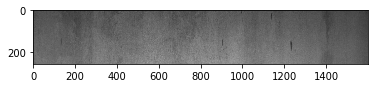

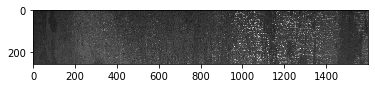

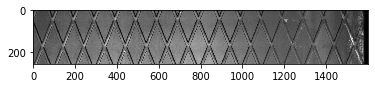

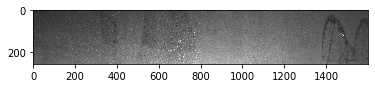

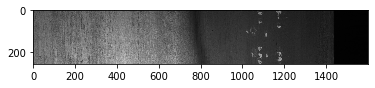

In [0]:
from matplotlib import pyplot
for i in range(5):
    disp= loaded_images[i]
    pyplot.imshow(disp)
    pyplot.show()

### 3.3.3 Basic properties of an image

In [0]:
from PIL import Image
# load the image
image = Image.open('0a5a82b86.jpg')
# summarize some details about the image
print(image.format)
print(image.mode)
print(image.size)
# show the image
image.show()

JPEG
RGB
(1600, 256)


### 3.3.4 Check if all images in train and test are of the same size

#### Train images

In [0]:
from PIL import Image
image_size=[]
for image_id in listdir('train_images'):
    img=Image.open("train_images/"+image_id)
    width,height=img.size
    image_size.append((width,height))

In [0]:
train_image_size_df=pd.DataFrame(image_size,columns=["width","height"])
train_image_size_df.head()

,width,height
0,1600,256
1,1600,256
2,1600,256
3,1600,256
4,1600,256


In [0]:
print(train_image_size_df.width.unique())
print(train_image_size_df.height.unique())

[1600]
[256]


#### Test images

In [0]:
from PIL import Image
image_size=[]
for image_id in listdir('test_images'):
    img=Image.open("test_images/"+image_id)
    width,height=img.size
    image_size.append((width,height))

In [0]:
test_image_size_df=pd.DataFrame(image_size,columns=["width","height"])
test_image_size_df.head()

,width,height
0,1600,256
1,1600,256
2,1600,256
3,1600,256
4,1600,256


In [0]:
print(test_image_size_df.width.unique())
print(test_image_size_df.height.unique())

[1600]
[256]


**Therefore all images in train and test folders have the same size of (1600,256)**

## 3.4 Analysis of response label: ClassId

### 3.4.1 Checking for class count

In [0]:
counts= train_df.ClassId.value_counts()
counts

3    5150
1     897
4     801
2     247
Name: ClassId, dtype: int64

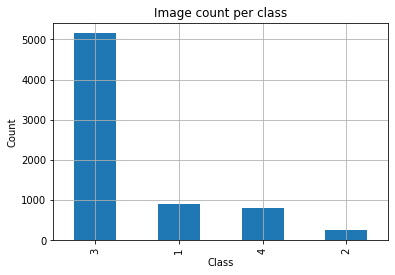

Number of images in class 3 : 5150 ( 72.586 %)
Number of images in class 1 : 897 ( 12.643 %)
Number of images in class 4 : 801 ( 11.29 %)
Number of images in class 2 : 247 ( 3.481 %)


In [0]:
my_colors = 'rgbkymc'
counts.plot(kind='bar')
plt.xlabel('Class')
plt.ylabel('Count')
plt.title('Image count per class')
plt.grid()
plt.show()

# ref: argsort https://docs.scipy.org/doc/numpy/reference/generated/numpy.argsort.html
# -(train_class_distribution.values): the minus sign will give us in decreasing order
sorted_counts = np.argsort(-counts.values)
for i in sorted_counts:
    k=[3,1,4,2]
    print('Number of images in class', k[i], ':',counts.values[i], '(', np.round((counts.values[i]/train_df.shape[0]*100), 3), '%)')

**Observations:**
- Number of images with class 3 defect is found to be maximum compared to other defect classes
- Images with class 2 defects are least found
- Therefore the dataset is imbalanced with dominance of Class 3 defects**

#### 3.4.1.1 Finding class weights

In [0]:
#https://scikit-learn.org/stable/modules/generated/sklearn.utils.class_weight.compute_class_weight.html
from sklearn.utils import class_weight
class_wts = class_weight.compute_class_weight('balanced', np.unique(train_df.ClassId.values),train_df.ClassId)
print(class_wts)
for i in range(len(class_wts)):
    print("Weight for class {}: {}".format(i+1,class_wts[i]))

[1.97742475 7.18117409 0.34441748 2.21441948]
Weight for class 1: 1.9774247491638797
Weight for class 2: 7.181174089068826
Weight for class 3: 0.34441747572815534
Weight for class 4: 2.2144194756554305


**Will be using these weights during training in the fit_generator function.**

### 3.4.2 Checking number of labels tagged to each image

In [0]:
labels_per_image = train_df.groupby('ImageId')['ClassId'].count()
labels_per_image.value_counts()

1    6239
2     425
3       2
Name: ClassId, dtype: int64

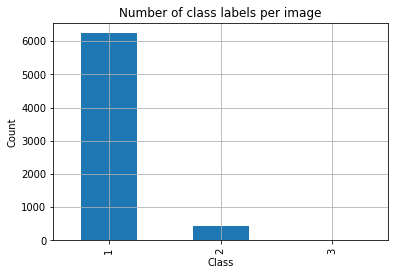

In [0]:
my_colors = 'rgbkymc'
labels_per_image.value_counts().plot(kind='bar')
plt.xlabel('Class')
plt.ylabel('Count')
plt.title('Number of class labels per image')
plt.grid()
plt.show()

**Observations:**
- There are 6239 steel sheet images possessing only one class of defect i.e. either 1,2,3 or 4
- There are 425 steel sheet images possessing a combination of 2 classes defects
- There are 2 steel sheet images possessing a combination of 3 classes defects
- There are no steel sheet images possessing a combination of 4 classes defects

### 3.4.3 Displaying few sample images belonging to each of the 4 classes

In [0]:
d1= train_df[train_df.ClassId==1]
d2= train_df[train_df.ClassId==2]
d3= train_df[train_df.ClassId==3]
d4= train_df[train_df.ClassId==4]

In [0]:
d1.head()

,ImageId,ClassId,EncodedPixels
0,0002cc93b.jpg,1,29102 12 29346 24 29602 24 29858 24 30114 24 3...
2,000a4bcdd.jpg,1,37607 3 37858 8 38108 14 38359 20 38610 25 388...
8,002fc4e19.jpg,1,146021 3 146275 10 146529 40 146783 46 147038 ...
18,008ef3d74.jpg,1,356336 4 356587 11 356838 18 357089 25 357340 ...
21,00ac8372f.jpg,1,101742 3 101998 12 102253 19 102301 22 102509 ...


#### Class-1

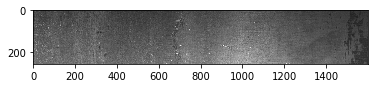

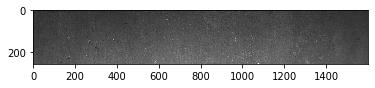

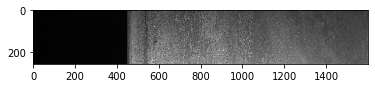

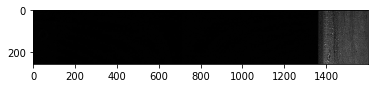

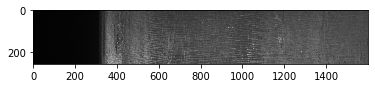

In [0]:
# load all images in a directory

from matplotlib import image
loaded_images = list()
img_names= list(d1.ImageId.values)
for filename in listdir('train_images'):
    if str(filename) in img_names:
# load image
        img_data = image.imread('train_images/' + filename)
# store loaded image
        loaded_images.append(img_data)

#displaying images
from matplotlib import pyplot
for i in range(5):
    disp= loaded_images[i]
    pyplot.imshow(disp)
    pyplot.show()

#### Class-2

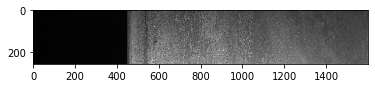

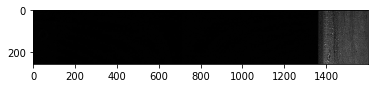

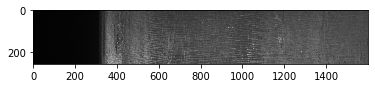

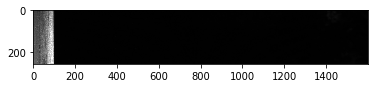

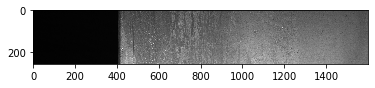

In [0]:
# load all images in a directory
loaded_images = list()
img_names= list(d2.ImageId.values)
for filename in listdir('train_images'):
    if str(filename) in img_names:
# load image
        img_data = image.imread('train_images/' + filename)
# store loaded image
        loaded_images.append(img_data)

#displaying images
from matplotlib import pyplot
for i in range(5):
    disp= loaded_images[i]
    pyplot.imshow(disp)
    pyplot.show()

#### Class-3

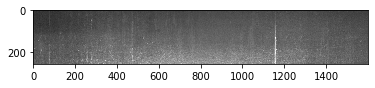

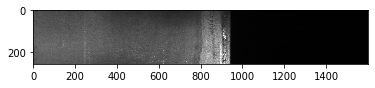

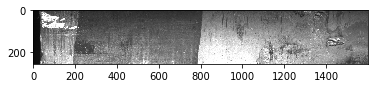

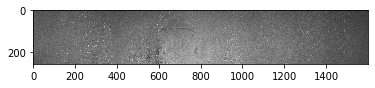

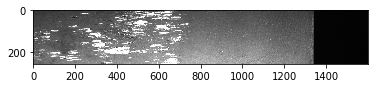

In [0]:
# load all images in a directory
loaded_images = list()
img_names= list(d3.ImageId.values)
for filename in listdir('train_images'):
    if str(filename) in img_names:
# load image
        img_data = image.imread('train_images/' + filename)
# store loaded image
        loaded_images.append(img_data)

#displaying images
from matplotlib import pyplot
for i in range(5):
    disp= loaded_images[i]
    pyplot.imshow(disp)
    pyplot.show()

#### Class-4

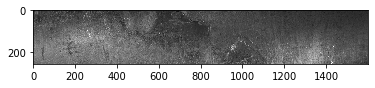

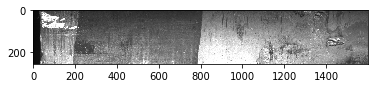

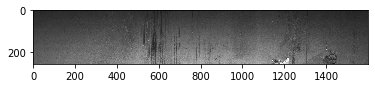

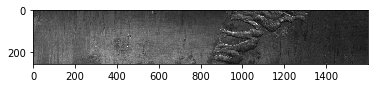

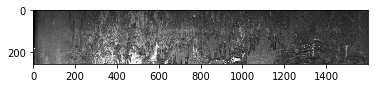

In [0]:
# load all images in a directory
loaded_images = list()
img_names= list(d4.ImageId.values)
for filename in listdir('train_images'):
    if str(filename) in img_names:
# load image
        img_data = image.imread('train_images/' + filename)
# store loaded image
        loaded_images.append(img_data)

#displaying images
from matplotlib import pyplot
for i in range(5):
    disp= loaded_images[i]
    pyplot.imshow(disp)
    pyplot.show()

# 4.0 Data preparation

## 4.1 Preparing defect data for each image

In [0]:
# preparing a dataframe with each image ID being represented with 4 classes
images= []
class_id= []
for img in listdir('train_images'):
    images.append(img)
    class_id.append(1)
    images.append(img)
    class_id.append(2)
    images.append(img)
    class_id.append(3)
    images.append(img)
    class_id.append(4)
train_images= pd.DataFrame(images,columns=['ImageId'])
train_images['ClassId'] = class_id
train_images.head()

,ImageId,ClassId
0,0002cc93b.jpg,1
1,0002cc93b.jpg,2
2,0002cc93b.jpg,3
3,0002cc93b.jpg,4
4,00031f466.jpg,1


In [0]:
train_images.shape

(50272, 2)

In [0]:
# Dataframe containing RLE(run length encoded pixels) representing defects
train_df.head()

,ImageId,ClassId,EncodedPixels
0,0002cc93b.jpg,1,29102 12 29346 24 29602 24 29858 24 30114 24 3...
1,0007a71bf.jpg,3,18661 28 18863 82 19091 110 19347 110 19603 11...
2,000a4bcdd.jpg,1,37607 3 37858 8 38108 14 38359 20 38610 25 388...
3,000f6bf48.jpg,4,131973 1 132228 4 132483 6 132738 8 132993 11 ...
4,0014fce06.jpg,3,229501 11 229741 33 229981 55 230221 77 230468...


In [0]:
# merging defect & non-defect data
temp_df = pd.merge(train_images, train_df,how='outer',on=['ImageId','ClassId'])
temp_df = temp_df.fillna('')
print(temp_df.shape)
temp_df.head()

(50272, 3)


,ImageId,ClassId,EncodedPixels
0,0002cc93b.jpg,1,29102 12 29346 24 29602 24 29858 24 30114 24 3...
1,0002cc93b.jpg,2,
2,0002cc93b.jpg,3,
3,0002cc93b.jpg,4,
4,00031f466.jpg,1,


In [0]:
# Grouping the data according to ImageID with each row representing images with single or multiple defects 
#https://www.geeksforgeeks.org/python-pandas-pivot_table/

defect_data = pd.pivot_table(temp_df, values='EncodedPixels', index='ImageId',columns='ClassId', aggfunc=np.sum).astype(str)
defect_data = defect_data.reset_index()
defect_data.columns = ['ImageId','Defect_1','Defect_2','Defect_3','Defect_4']
defect_data.head()

,ImageId,Defect_1,Defect_2,Defect_3,Defect_4
0,0002cc93b.jpg,29102 12 29346 24 29602 24 29858 24 30114 24 3...,,,
1,00031f466.jpg,,,,
2,000418bfc.jpg,,,,
3,000789191.jpg,,,,
4,0007a71bf.jpg,,,18661 28 18863 82 19091 110 19347 110 19603 11...,


In [0]:
defect_data.shape

(12568, 5)

## 4.2 Splitting the data into train & CV

In [0]:
from sklearn.model_selection import train_test_split
data= defect_data
train_data, cv_data = train_test_split(data, test_size=0.15)
print(train_data.shape)
print(cv_data.shape)

(10682, 5)
(1886, 5)


# 5.0 Utility functions

## 5.1 Mask encoding and decoding

In [0]:
# to convert masks to run length encoded values
#https://www.kaggle.com/aleksandradeis/steel-defect-detection-eda

def mask2rle(img):
    '''
    img: numpy array, 1 - mask, 0 - background
    Returns run length as string formated
    '''
    pixels= img.T.flatten()
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)

In [0]:
# to convert run length encoded pixels to masks
#https://www.kaggle.com/aleksandradeis/steel-defect-detection-eda
def rle2mask(rle):
    '''
    Returns mask array by converting run length encoded pixels
    
    '''
  # If rle is empty or null
    if(len(rle)<1): 
        return np.zeros((128,800) ,dtype=np.uint8)
    
    height = 256
    width = 1600
    # Defining the length of mask. This will be a 1d array which will be reshaped to 2d later.
    mask = np.zeros(height*width ).astype(np.uint8)
    array = np.asarray([int(x) for x in rle.split()]) # array containing rle
    start = array[0::2]-1 # this willl contain the start of run length
    length = array[1::2] # this will contain the length of each rle.
    for i,start in enumerate(start):
        mask[int(start):int(start+length[i])] = 1
    return mask.reshape( (height,width), order='F' )[::2,::2]

## 5.2 Custom metric and loss function

In [0]:
from keras import backend as K
from keras.losses import binary_crossentropy
#https://lars76.github.io/neural-networks/object-detection/losses-for-segmentation/
#https://www.kaggle.com/wh1tezzz/correct-dice-metrics-for-this-competition
#https://forums.fast.ai/t/understanding-the-dice-coefficient/5838

def dice_coef(y_true, y_pred, smooth=1):
    ''' Function that returns dice coefficient by taking input masks and predicted masks'''
    
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)
  
def  bce_dice_loss(y_true, y_predict): #combination of dice loss and binary cross entropy for all pixels
    return binary_crossentropy(y_true, y_predict) + (1-dice_coef(y_true, y_predict))

## 5.3 Training Plots

In [0]:
from matplotlib import pyplot
def plot(history):
    '''function to plot epoch vs bce_dice_loss & epoch vs dice_coeff '''
    # plot bce_dice_loss
    pyplot.subplot(121)
    pyplot.title('bce_dice_loss')
    pyplot.xlabel('Epoch')
    pyplot.plot(history.history['loss'], color='blue', label='train')
    pyplot.plot(history.history['val_loss'], color='orange', label='CV')
    # plot dice_coeff
    pyplot.subplot(122)
    pyplot.title('Dice_coef')
    pyplot.xlabel('Epoch')
    pyplot.plot(history.history['dice_coef'], color='blue', label='train')
    pyplot.plot(history.history['val_dice_coef'], color='orange', label='CV')

## 5.4 Visualizing defects for train & validation images

In [0]:
def visualize_defects(data,model):
    ''' Function that takes data containing imageID's ,model and outputs 4 masks for each image '''
    
    import random
    image_id= list(data.ImageId.values)
    for i in random.sample(image_id, 5):
        df= data[data.ImageId==i]
        X = np.empty((1,128,800,3),dtype=np.float32)
        img = cv2.imread('/content/' +'train_images/' + i)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, (800,128))
        X[0,] = img
        mask_pred = model.predict(X)
        fig, axs = plt.subplots(4,3,figsize=(18, 7))
        axs[0,0].imshow(img)
        axs[0,0].set_title(i)
        for j in range(4):
            
            if j<3:
                axs[j+1,0].axis('off')
            k=0
            gt= rle2mask(df.iloc[0][j+1])
            m = mask_pred[0,:,:,j].round().astype(int)
            axs[j,k+1].imshow(gt)
            axs[j,k+1].set_title('Ground truth mask: Class_'+str(j+1))
            axs[j,k+2].imshow(m)
            axs[j,k+2].set_title('Predicted mask: Class_'+str(j+1))
        plt.show()
        print('-'*100)

## 5.5 Visualizing defects on raw test images

In [0]:
def visualize_defects_test(data,n):
    
    ''' Function that takes test ImageID's and the number of images to display as input and therefore outputs 
    mask with class ID'''
    
    data= data[data['EncodedPixels']!='']
    for i in random.sample(list(data['ImageId_ClassId'].values), n): 
        df= data[data.ImageId_ClassId==i]
        img = Image.open('/content/' +'test_images/' + i.split('_')[0])
        pixels= df.iloc[0][1]
        mask= rle2mask(pixels)
        fig, (ax1,ax2) = plt.subplots(1,2,figsize=(15, 7))
        ax1.imshow(img)
        ax1.set_title(i.split('_')[0])
        ax2.imshow(mask)
        ax2.set_title('Predicted mask with Class-'+i.split('_')[1]+' defect.')
        plt.show()
        print('-'*150)

# 6.0 Check rle2mask function and visualize few masks & images

Sample images with Class 1 defect:


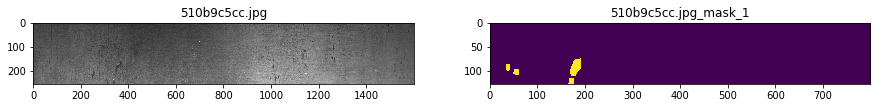

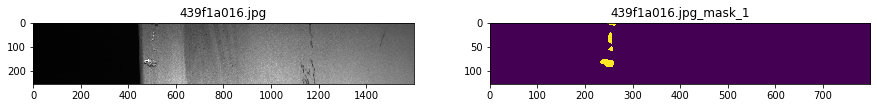

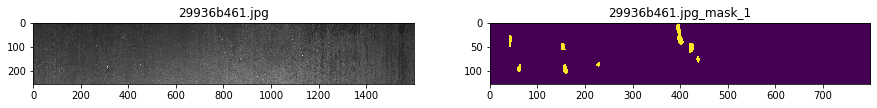

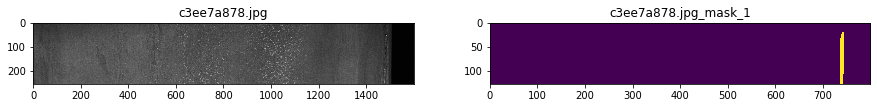

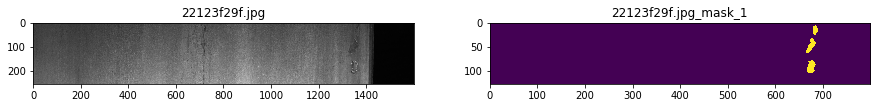

----------------------------------------------------------------------------------------------------
Sample images with Class 2 defect:


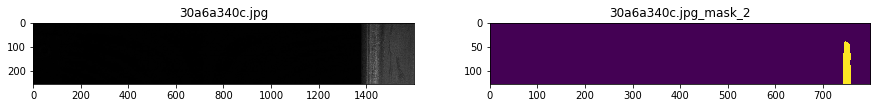

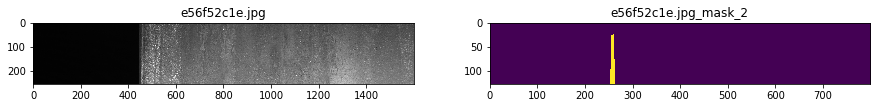

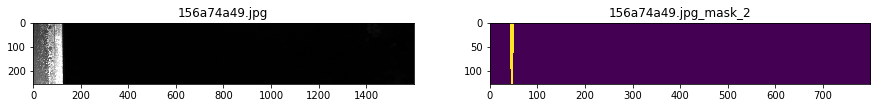

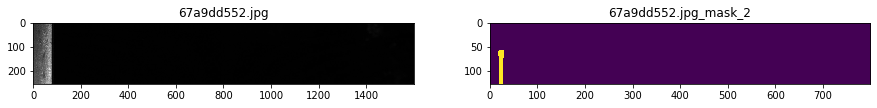

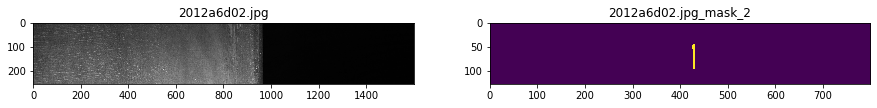

----------------------------------------------------------------------------------------------------
Sample images with Class 3 defect:


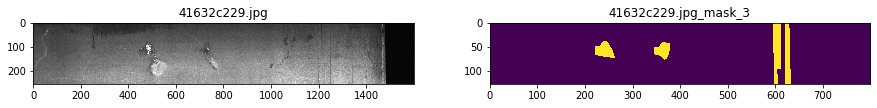

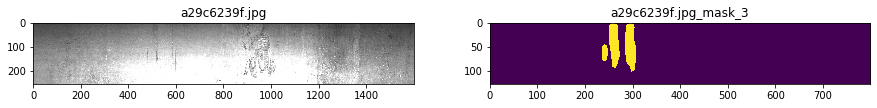

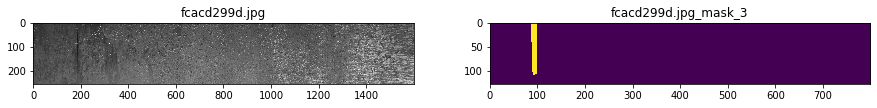

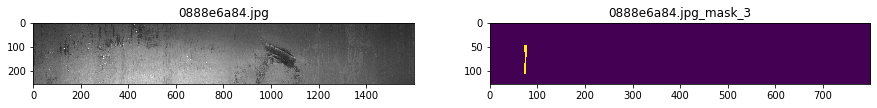

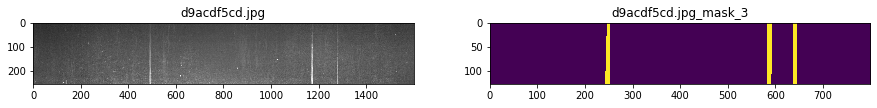

----------------------------------------------------------------------------------------------------
Sample images with Class 4 defect:


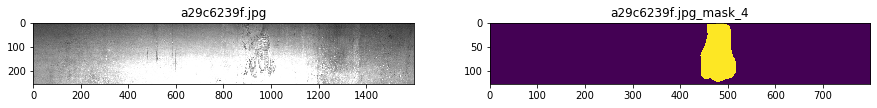

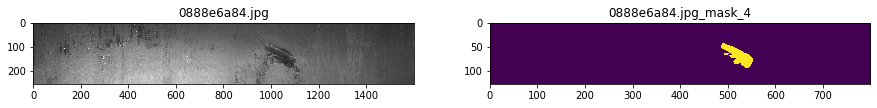

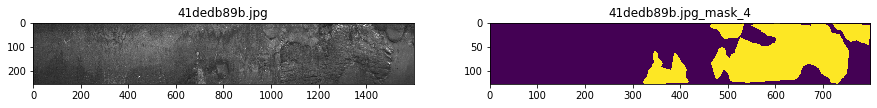

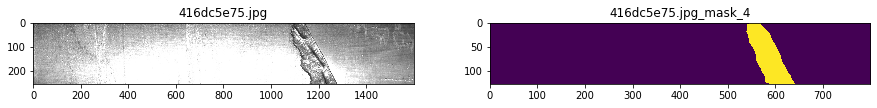

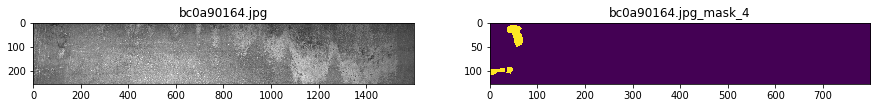

----------------------------------------------------------------------------------------------------


In [0]:
for k in [1,2,3,4]: #classes
    tmp = []
    cnt=0
    print("Sample images with Class {} defect:".format(k))
    for i in train_data[train_data[f'Defect_{k}']!=''][['ImageId',f'Defect_{k}']].values:
        if cnt<5:
            fig, (ax1,ax2) = plt.subplots(nrows = 1,ncols = 2,figsize=(15, 7))
            img = Image.open('train_images/' + str(i[0]))
            ax1.imshow(img)
            ax1.set_title(i[0])
            cnt+=1
            ax2.imshow(rle2mask(i[1]))
            ax2.set_title(i[0]+'_mask_'+str(k))
            plt.show()
    print('-'*100)

# 7.0 Generating data for Keras model

## 7.1 Train generator

In [0]:
# https://stanford.edu/~shervine/blog/keras-how-to-generate-data-on-the-fly
# https://keras.io/preprocessing/image/

import keras
from keras.preprocessing.image import ImageDataGenerator
class Train_DataGenerator(keras.utils.Sequence):
    def __init__(self, df, batch_size = 16,shuffle=False, 
                 preprocess=None, info={}):
        super().__init__()
        self.df = df
        self.shuffle = shuffle
        self.batch_size = batch_size
        self.preprocess = preprocess
        self.info = info
        self.data_path = '/content/' + 'train_images/'
        self.on_epoch_end()
        
    def __len__(self):
        return int(np.floor(len(self.df) / self.batch_size))
    
    def on_epoch_end(self):
        self.indexes = np.arange(len(self.df))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)
    
    def __getitem__(self, index):
        train_datagen = ImageDataGenerator()
        param = {'flip_horizontal':True, 'flip_vertical' : True}
        '''' 
        Performing data augmentation on images and the masks generated which includes Horizontal flip &  Vertical flip
        
        '''
        X = np.empty((self.batch_size,128,800,3),dtype=np.float32) #images
        y = np.empty((self.batch_size,128,800,4),dtype=np.int8)    #masks
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]
        for i,f in enumerate(self.df['ImageId'].iloc[indexes]):
            self.info[index*self.batch_size+i]=f
            img = Image.open(self.data_path + f).resize((800,128))
            X[i,] = train_datagen.apply_transform(x = img, transform_parameters = param)
                #run-length encoding on the pixel values
            for j in range(4):
                mask= rle2mask(self.df['Defect_'+str(j+1)].iloc[indexes[i]])
                y[i,:,:,j] = train_datagen.apply_transform(x = mask, transform_parameters = param)
        if self.preprocess!=None: X = self.preprocess(X)
        return X, y

## 7.2 Validation generator(Without Augmentation)

In [0]:
# https://stanford.edu/~shervine/blog/keras-how-to-generate-data-on-the-fly

import keras
from keras.preprocessing.image import ImageDataGenerator
class Val_DataGenerator(keras.utils.Sequence):
    def __init__(self, df, batch_size = 16,shuffle=False, 
                 preprocess=None, info={}):
        super().__init__()
        self.df = df
        self.shuffle = shuffle
        self.batch_size = batch_size
        self.preprocess = preprocess
        self.info = info
        self.data_path = '/content/' + 'train_images/'
        self.on_epoch_end()
        
    def __len__(self):
        return int(np.floor(len(self.df) / self.batch_size))
    
    def on_epoch_end(self):
        self.indexes = np.arange(len(self.df))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)
            
    def __getitem__(self, index):
        
        X = np.empty((self.batch_size,128,800,3),dtype=np.float32) #images
        y = np.empty((self.batch_size,128,800,4),dtype=np.int8)    #masks
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]
        for i,f in enumerate(self.df['ImageId'].iloc[indexes]):
            self.info[index*self.batch_size+i]=f
            X[i,] = Image.open(self.data_path + f).resize((800,128))
            #run-length encoding on the pixel values
            for j in range(4):
                y[i,:,:,j] = rle2mask(self.df['Defect_'+str(j+1)].iloc[indexes[i]])
        if self.preprocess!=None: X = self.preprocess(X)
        return X, y